In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI
from pyro.optim import Adam

import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# from jupyterthemes import jtplot
# jtplot.style('oceans16')
%matplotlib inline


In [3]:
TARGET = 'SalePrice'
NFOLDS = 5
SEED = 0
NROWS = None
SUBMISSION_FILE = '../input/sample_submission.csv'


## Load the data ##
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

ntrain = train.shape[0]
ntest = test.shape[0]

## Preprocessing ##

y_train = np.log1p(train[TARGET])


train.drop([TARGET], axis=1, inplace=True)


all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))


#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:

x_train = np.array(all_data[:train.shape[0]])
x_test = np.array(all_data[train.shape[0]:])
N, D = x_train.shape

In [4]:
X_train = Variable(torch.from_numpy(np.float32(scale(x_train))))
prices = Variable(torch.from_numpy(np.float32(y_train)))


In [5]:
class LR(nn.Module):
    def __init__(self, D):
        super(LR, self).__init__()
        self.L = nn.Linear(D, 1)
        
    def forward(self, x):
        return self.L(x)
        

In [6]:
net = LR(D)

In [7]:
def model(data):
    # Create unit normal priors over the parameters
    x_data = data[0]
    y_data = data[1]
    mu, sigma = Variable(torch.zeros(1, D)), Variable(10 * torch.ones(1, D))
    bias_mu, bias_sigma = Variable(torch.zeros(D)), Variable(10 * torch.ones(D))
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    # run the regressor forward conditioned on data
    prediction_mean = lifted_reg_model(x_data).squeeze()
    # condition on the observed data
    pyro.observe("obs", Normal(prediction_mean, Variable(0.1 * torch.ones(N))),
                 y_data.squeeze())

In [8]:
softplus = torch.nn.Softplus()

def guide(data):
    # define our variational parameters
    w_mu = Variable(torch.randn(1, D), requires_grad=True)
    # note that we initialize our sigmas to be pretty narrow
    w_log_sig = Variable(-0.1 * torch.ones(1, D) + 0.05 * torch.randn(1, D),
                         requires_grad=True)
    b_mu = Variable(torch.randn(D), requires_grad=True)
    b_log_sig = Variable(-0.1 * torch.ones(D) + 0.05 * torch.randn(D),
                         requires_grad=True)
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    # guide distributions for w and b
    w_dist, b_dist = Normal(mw_param, sw_param), Normal(mb_param, sb_param)
    dists = {'linear.weight': w_dist, 'linear.bias': b_dist}
    # overload the parameters in the module with random samples
    # from the guide distributions
    lifted_module = pyro.random_module("module", net, dists)
    # sample a regressor (which also samples w and b)
    return lifted_module()

In [28]:
optim = Adam({"lr": 0.004})
svi = SVI(model, guide, optim, loss="ELBO")

In [29]:
pyro.clear_param_store()
num_iterations = 20000
data  = [X_train, prices]
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 1000  == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / float(N)))


[iteration 0001] loss: 7314.7384
[iteration 1001] loss: 3513.2921
[iteration 2001] loss: 1399.9009
[iteration 3001] loss: 401.3939
[iteration 4001] loss: 63.0458
[iteration 5001] loss: 2.4944
[iteration 6001] loss: -0.9361
[iteration 7001] loss: -0.9560
[iteration 8001] loss: -0.9629
[iteration 9001] loss: -0.9638
[iteration 10001] loss: -0.9563
[iteration 11001] loss: -0.9633
[iteration 12001] loss: -0.9638
[iteration 13001] loss: -0.9638
[iteration 14001] loss: -0.9638
[iteration 15001] loss: -0.9631
[iteration 16001] loss: -0.9638
[iteration 17001] loss: -0.9617
[iteration 18001] loss: -0.9637
[iteration 19001] loss: -0.9638


In [30]:
mod = guide(None)
guess = mod(X_train)
# err = rmse(guess, prices)
# err
# for name in pyro.get_param_store().get_all_param_names():
#     print((name, pyro.param(name).data.numpy()))


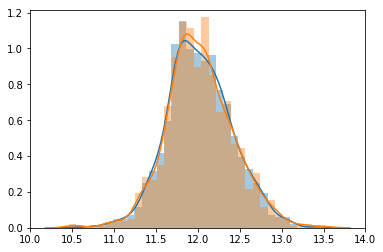

In [31]:
sns.distplot(guess.data.numpy())
sns.distplot(prices.data.numpy())

In [32]:
def rmse(input, target):
    return torch.sqrt(torch.mean(torch.pow(input - target, 2)))

err = rmse(mod(X_train), prices)
err

Variable containing:
 0.5572
[torch.FloatTensor of size 1]

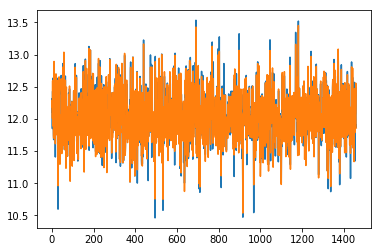

In [33]:
plt.plot(prices.data.numpy())
plt.plot(guess.data.numpy())

In [34]:
X_test = Variable(torch.from_numpy(np.float32(scale(x_test))))

obs = Variable(torch.zeros(X_test.size(0), 10))
# guess = mod(X_test)
for ind in range(10):
    mod = guide(None)
    guess = mod(X_test)
    obs[:, ind] = guess
    


LinAlgError: singular matrix

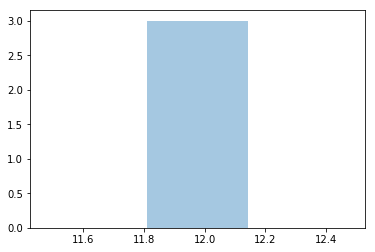

In [35]:
sns.distplot(obs[1,:].data.numpy())

In [36]:
guess = guess.data.numpy()
guess

array([[ 11.72340298],
       [ 11.97699833],
       [ 12.14890003],
       ..., 
       [ 12.08885384],
       [ 11.72463894],
       [ 12.33375359]], dtype=float32)

In [39]:
sns.distplot(guess.data.numpy())
sns.distplot(prices.data.numpy())

AttributeError: 'memoryview' object has no attribute 'numpy'

In [38]:
test_ID = test['Id']

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(guess)
sub.to_csv('submission.csv',index=False)

In [ ]:
all_data.shape

In [ ]:
obs

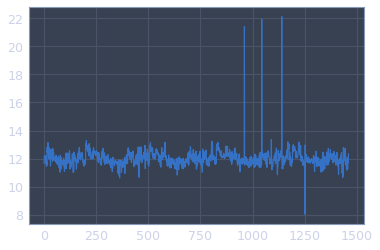

In [95]:
x = np.linspace(0,N-1, N-1)
plt.plot(x,guess)
plt.fill_between(x, guess-guess_std, guess+guess_std)

In [40]:
np.corrcoef(gues.T)

1.0

In [44]:
a = [mod(X_test).data.numpy() , mod(X_test).data.numpy()]

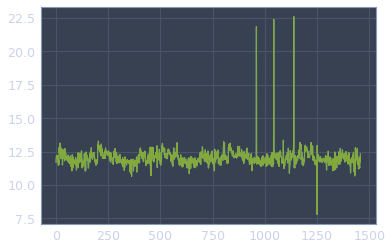

In [50]:
plt.plot(np.asarray(a).squeeze().T);

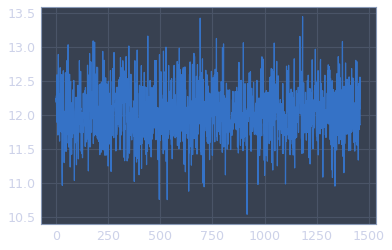

In [53]:
plt.plot(mod(X_train).data.numpy())